# CSCN8020 – Assignment 3  
## Deep Q-Learning on Atari Pong (TensorFlow Version)

**Student Name:** Haysam Elamin  
**Student ID:** 8953681  

This notebook implements a Deep Q-Network (DQN) agent to play **Atari Pong**,
using **Gymnasium** and **TensorFlow/Keras**.

It also connects conceptually to the **Multi-Armed Bandit / Exploration Strategies**
workshop, explored ε-greedy, stationary and non-stationary
casinos.


## Notebook Outline

1. Environment & Library Setup  
2. Pong Environment Overview  
3. Frame Preprocessing (Cropping, Downsampling, Grayscale, Normalization)  
4. DQN Agent (TensorFlow/Keras) – Architecture & Replay Buffer  
5. Training Loop (ε-greedy, Experience Replay, Target Network)  
6. Results & Visualizations (Rewards over Episodes, Example Frames)  
7. Reflections: Exploration vs Exploitation & Link to Casino Exercise  


In [15]:
# 1. Environment & Library Setup

import os
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym  # Newer version of gym
import tensorflow as tf

from assignment3_utility import process_frame, transform_reward
from assignment3_agent_tf import DQNAgent

# Make plots inline
%matplotlib inline

# Ensure reproducibility (as much as possible)
np.random.seed(42)
tf.random.set_seed(42)


## 2. Pong Environment Overview

We use the **`ALE/Pong-v5`** environment from Gymnasium, which simulates the classic Atari Pong game.

- **Observation:** RGB frames of size 210×160×3.  
- **Actions:** Discrete actions such as:
  - 0: NOOP (no operation)
  - 2: Move paddle **up**
  - 3: Move paddle **down**

We will wrap the environment so that:

- Frames are preprocessed using our `process_frame` function.  
- We apply the new Gymnasium API (`reset()` returns `(obs, info)` and `step()` returns `(obs, reward, terminated, truncated, info)`).


In [16]:
# Create Pong environment
################# Note: If ALE/Pong-v5 is not installed, you may need:
############## pip install "gymnasium[atari,accept-rom-license]"
env = gym.make("ALE/Pong-v5", render_mode=None)

obs, info = env.reset()
print("Raw observation shape:", obs.shape)
print("Action space:", env.action_space)


Raw observation shape: (210, 160, 3)
Action space: Discrete(6)


## 3. Frame Preprocessing

The raw Pong frames are large and contain many irrelevant details (score, borders, backgrounds).

We apply the following steps:

1. **Crop** the top and bottom to remove borders and HUD.  
2. **Downsample** by 2 to reduce resolution and speed up training.  
3. Convert to **grayscale** (1 channel instead of 3).  
4. **Normalize** to the range [-1, 1] to stabilize neural network training.  
5. Reshape to `(1, H, W, 1)` so it can be fed into a Keras CNN.

These steps are implemented in `assignment3_utility.py` in the `process_frame()` function.


Processed frame shape: (1, 80, 80, 1)


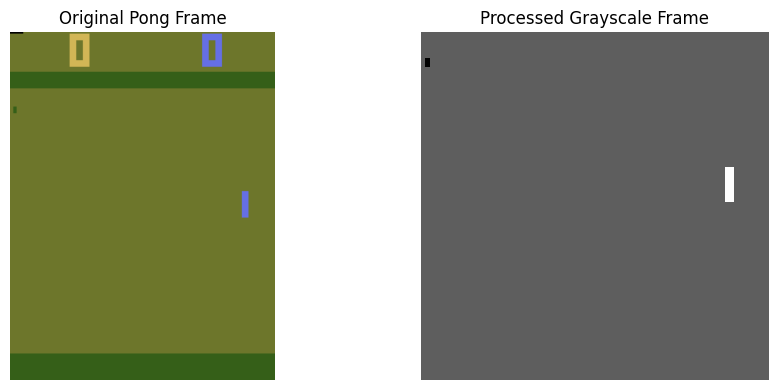

In [17]:
# Test frame preprocessing
IMAGE_SHAPE = (80, 80)  # desired (H, W)

processed = process_frame(obs, IMAGE_SHAPE)
print("Processed frame shape:", processed.shape)  # Expect (1, 80, 80, 1)

# Visualize original vs processed ( to see the effect)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Pong Frame")
plt.imshow(obs)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Processed Grayscale Frame")
plt.imshow(processed[0, :, :, 0], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


## 4. DQN Agent (TensorFlow/Keras)

We implement a **Deep Q-Network (DQN)** agent, which uses:

- A **Convolutional Neural Network (CNN)** to map images → Q-values.
- An **experience replay buffer** to break correlation between consecutive samples.
- A **target network** to stabilize learning.
- An **ε-greedy policy** to balance exploration vs exploitation:
  - Start with ε = 1.0 (mostly random actions).
  - Gradually decay ε to 0.1 over 1 million frames.

The implementation is located in `assignment3_agent_tf.py` and exposes:

- `DQNAgent` class
- `select_action(state)` for training (ε-greedy)
- `select_greedy_action(state)` for evaluation
- `train_step()` to perform one gradient update


In [18]:
# Determine state shape for the agent
state_shape = (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)  # (H, W, C)
num_actions = env.action_space.n

agent = DQNAgent(
    state_shape=state_shape,
    num_actions=num_actions,
    gamma=0.99,
    buffer_capacity=100_000,
    batch_size=32,
    min_replay_size=10_000,      # start learning after collecting enough data
    epsilon_start=1.0,
    epsilon_end=0.1,
    epsilon_decay_frames=1_000_000,
    target_update_freq=10_000
)

print("Agent initialized with state shape:", state_shape)
print("Number of actions:", num_actions)


Agent initialized with state shape: (80, 80, 1)
Number of actions: 6


## 5. Training Loop

The training loop performs the following steps per episode:

1. **Reset** the environment and preprocess the first frame as the initial state.  
2. For each time step:
   - Select an action using the agent's **ε-greedy policy**.
   - Apply the action using `env.step(action)` (Gymnasium API).
   - Preprocess the next frame.
   - Transform reward using `transform_reward()`.
   - Store the transition in the replay buffer.
   - Call `agent.train_step()` to update the Q-network (once enough data exists).
3. If `done` (episode is over), log total reward and start a new episode.
4. Periodically plot and save training curves.

We will limit the number of episodes here for demonstration, but the full training often requires many more episodes for good performance.


In [19]:
import time

NUM_EPISODES = 20         # keep small for testing; increase for real training
MAX_STEPS_PER_EPISODE = 500

episode_rewards = []      # track total reward per episode
losses = []               # track training loss when available

for episode in range(1, NUM_EPISODES + 1):
    obs, info = env.reset()
    state = process_frame(obs, IMAGE_SHAPE)  # (1, H, W, 1)

    total_reward = 0.0
    episode_loss = []

    for t in range(MAX_STEPS_PER_EPISODE):
        # 1. Select action using epsilon-greedy
        action = agent.select_action(state)

        # 2. Step the environment (new Gymnasium API)
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # 3. Transform reward (e.g., sign)
        reward = transform_reward(reward)

        # 4. Preprocess next observation
        next_state = process_frame(next_obs, IMAGE_SHAPE)

        # 5. Store transition in replay buffer
        agent.store_transition(state, action, reward, next_state, done)

        # 6. Perform one training step (if enough data)
        loss = agent.train_step()
        if loss is not None:
            episode_loss.append(loss)

        state = next_state
        total_reward += reward

        if done:
            break

    episode_rewards.append(total_reward)
    mean_loss = np.mean(episode_loss) if episode_loss else np.nan
    losses.append(mean_loss)

    print(
        f"Episode {episode}/{NUM_EPISODES} "
        f"| Total Reward: {total_reward:.2f} "
        f"| Mean Loss: {mean_loss:.4f} "
        f"| Replay Buffer Size: {len(agent.replay_buffer)}"
    )


Episode 1/20 | Total Reward: -11.00 | Mean Loss: nan | Replay Buffer Size: 500
Episode 2/20 | Total Reward: -12.00 | Mean Loss: nan | Replay Buffer Size: 1000
Episode 3/20 | Total Reward: -11.00 | Mean Loss: nan | Replay Buffer Size: 1500
Episode 4/20 | Total Reward: -12.00 | Mean Loss: nan | Replay Buffer Size: 2000
Episode 5/20 | Total Reward: -12.00 | Mean Loss: nan | Replay Buffer Size: 2500
Episode 6/20 | Total Reward: -12.00 | Mean Loss: nan | Replay Buffer Size: 3000
Episode 7/20 | Total Reward: -11.00 | Mean Loss: nan | Replay Buffer Size: 3500
Episode 8/20 | Total Reward: -11.00 | Mean Loss: nan | Replay Buffer Size: 4000
Episode 9/20 | Total Reward: -7.00 | Mean Loss: nan | Replay Buffer Size: 4500
Episode 10/20 | Total Reward: -11.00 | Mean Loss: nan | Replay Buffer Size: 5000
Episode 11/20 | Total Reward: -12.00 | Mean Loss: nan | Replay Buffer Size: 5500
Episode 12/20 | Total Reward: -11.00 | Mean Loss: nan | Replay Buffer Size: 6000
Episode 13/20 | Total Reward: -8.00 | M

## 6. Results & Visualizations

We visualize:

- Episode total reward vs episode index.
- (Optionally) Mean loss per episode.

This helps us see whether the agent is improving over time.


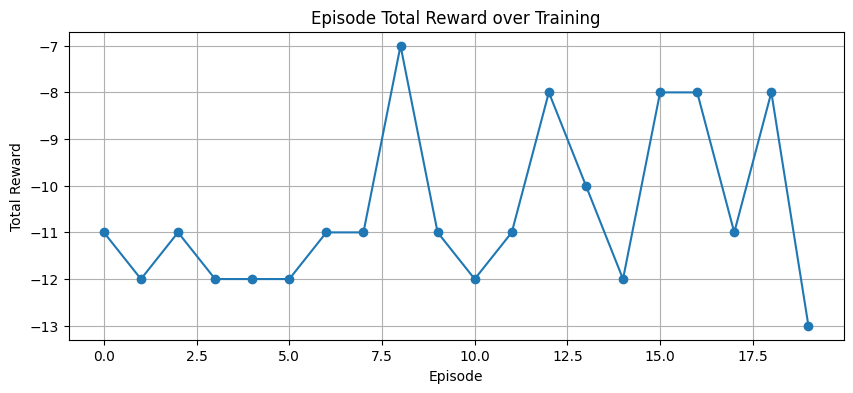

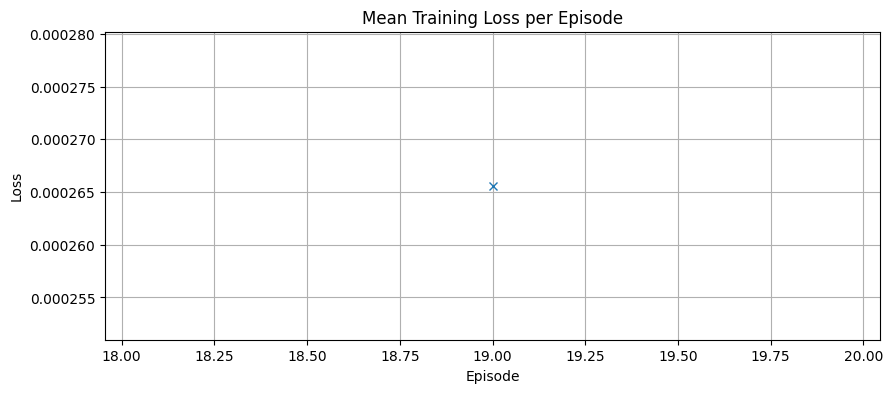

In [20]:
# Plot episode rewards
plt.figure(figsize=(10, 4))
plt.plot(episode_rewards, marker='o')
plt.title("Episode Total Reward over Training")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

# Plot mean loss per episode (may be noisy or NaN at start)
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='x')
plt.title("Mean Training Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### Optional: Save Trained Model

We can save the trained online Q-network in the newer `.keras` format (not `.h5`),
so it can be reloaded later for evaluation or demonstration.

This step is **optional** and not required by the assignment,
but useful for re-running the agent without retraining.


In [21]:
os.makedirs("models", exist_ok=True)
model_path = os.path.join("models", "pong_dqn_model.keras")

agent.save(model_path)
print("Model saved to:", model_path)


Model saved to: models\pong_dqn_model.keras


## 7. Reflections: Exploration vs Exploitation & Connection to Casino Exercise

In the **Multi-Armed Bandit workshop (Exercise 1)**, we saw:

- ε-greedy with different ε values (e.g., 0.1, 0.01).
- Stationary vs non-stationary reward distributions.
- The impact of constant step size (α) in non-stationary settings.

In this **Pong DQN assignment**, we see similar ideas:

- The DQN agent uses **ε-greedy**:
  - Starts with ε = 1.0 (pure exploration).
  - Gradually decays to ε = 0.1 (more exploitation).
- When ε is too high → the agent behaves randomly (like constantly exploring in the casino).
- When ε is too low too early → the agent may get stuck in a suboptimal policy (greedy choice based on limited experience).

The **experience replay buffer** also plays a role similar to having a
larger sample of past pulls in the casino:
- It reduces variance and stabilizes learning.
- It lets the agent "remember" many different states and rewards.

Finally, the **target network** acts as a slowly-changing reference,
reducing the risk of chasing non-stationary targets, similar to how
using a stable estimate of the true arm values helps in the casino.

You can further explore:
- Different ε decay schedules (slower/faster).
- Different replay buffer sizes.
- Different network architectures.

These experiments strengthen the understanding of the **exploration–exploitation trade-off**
across both the bandit setting and the full RL setting with Pong.
